In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import VBBinaryLensing
from scipy.optimize import minimize, fmin

import os
import torch
import h5py
from tqdm.notebook import tqdm
import torchcde
from scipy.signal import find_peaks
import MulensModel as mm
import corner
from model.utils import inference, get_loglik, get_peak_pred, plot_params, simulate_lc
from matplotlib.offsetbox import AnchoredText

torch.random.manual_seed(42)
np.random.seed(42)
plt.rcParams["font.family"] = "serif"
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'

In [2]:
with h5py.File('/work/hmzhao/irregular-lc/KMT-fixrho-test.h5', mode='r') as dataset_file:
    Y = torch.tensor(dataset_file['Y'][...])
    X = torch.tensor(dataset_file['X'][...])

# filter nan
nanind = torch.where(~torch.isnan(X[:, 0, 1]))[0]
Y = Y[nanind]
X = X[nanind]
nanind = torch.where(Y[:, 2]>0)[0]
Y = Y[nanind]
X = X[nanind]
nanind = torch.where(Y[:, 2]<1)[0]
Y = Y[nanind]
X = X[nanind]

Y[:, 3:6] = torch.log10(Y[:, 3:6])
Y[:, -1] = torch.log10(Y[:, -1])
Y[:, 6] = Y[:, 6] / 180
# Y = Y[:, 2:]
Y = Y[:, [2, 4, 5, 6, 7]]
print('Shape of Y: ', Y.shape)

X[:, :, 1] = (X[:, :, 1] - 14.5 - 2.5 * Y[:, [-1]]) / 0.2
print(f'normalized X mean: {torch.mean(X[:, :, 1])}\nX std: {torch.mean(torch.std(X[:, :, 1], axis=0))}')

X = X[:, :, :2]
    
# CDE interpolation with log_sig
depth = 3; window_length = 5
logsig = torchcde.logsig_windows(X, depth, window_length=window_length)
coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(logsig)

Shape of Y:  torch.Size([100000, 5])
normalized X mean: -1.1743464469848672
X std: 1.046597228312195


In [3]:
from model.cde_mdn import CDE_MDN

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

checkpt = torch.load('/work/hmzhao/experiments/cde_mdn/experiment_l32nG12diag.ckpt', map_location='cpu')
ckpt_args = checkpt['args']
state_dict = checkpt['state_dict']

output_dim = Y.shape[-1]
input_dim = logsig.shape[-1]
latent_dim = ckpt_args.latents

model = CDE_MDN(input_dim, latent_dim, output_dim).to(device)
# model = CDE_MDN(input_dim, latent_dim, output_dim, 32).to(device)
model_dict = model.state_dict()

# 1. filter out unnecessary keys
state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(state_dict) 
# 3. load the new state dict
model.load_state_dict(state_dict)
model.to(device)

CDE_MDN(
  (cde_func): CDEFunc(
    (linear1): Linear(in_features=32, out_features=1024, bias=True)
    (relu1): PReLU(num_parameters=1)
    (resblocks): Sequential(
      (0): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (1): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (2): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
    )
    (relu2): PReLU(num_parameters=1)
    (linear2): Linear(in_features=1024, out_features=160, bias=True)
    (tanh): Tanh()
    (linear3): Linear(in_features=

In [4]:
size = 4096 * 4

In [5]:
pis, locs, scales = inference(model, size, min(4096, size), coeffs, device, full_cov=False)

  0%|          | 0/4 [00:00<?, ?it/s]

In [6]:
pred_global, pred_global_loglik, pred_close, pred_close_loglik = get_peak_pred(pis, locs, scales, Y, n_step=1000)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

In [7]:
def prepare_lc_mdn(X, pis, locs):
    mag = X[:, :, 1] / 5 + 18
    flux = 10 ** (0.4 * (18 - mag))
    merr = torch.ones_like(mag) * 0.033
    ferr = merr*flux*np.log(10)/2.5
    # times, mag, flux, ferr
    lc = torch.stack([X[:, :, 0], mag, flux, ferr], dim=-1)
    first_indices = torch.arange(len(pis))[:, None]
    order = torch.argsort(pis, dim=-1, descending=True)
    pis = pis[first_indices, order]
    locs = locs[first_indices, order]
    return lc.numpy(), pis.numpy(), locs.numpy()

In [8]:
lc, pis_sort, locs_sort = prepare_lc_mdn(X[:size], pis, locs)

In [9]:
def get_fsfb(amp, flux, ferr):
    sig2 = ferr**2
    wght = flux/sig2
    d = np.ones(2)
    d[0] = np.sum(wght*amp)
    d[1] = np.sum(wght)
    b = np.zeros((2,2))
    b[0,0] = np.sum(amp**2/sig2)
    b[0,1] = np.sum(amp/sig2)
    b[1,0] = b[0,1]
    b[1,1] = np.sum(1./sig2)
    c = np.linalg.inv(b)
    fs = np.sum(c[0]*d)
    fb = np.sum(c[1]*d)
    fserr = np.sqrt(c[0,0])
    fberr = np.sqrt(c[1,1])
    fmod = fs*amp+fb
    chi2 = np.sum((flux-fmod)**2/sig2)
    return chi2,fs,fb,fserr,fberr

def compute_model_lc(time_array, fitting_parameters, VBBL):
    u0, lgq, lgs, ad180 = fitting_parameters
    q, s = 10**lgq, 10**lgs
    alpha = ad180 * np.pi # convert to radian
    t0, te, rho = 0, 1, 1e-3
    tau = (time_array-t0)/te
    xs = tau*np.cos(alpha) - u0*np.sin(alpha)
    ys = tau*np.sin(alpha) + u0*np.cos(alpha)
    magnifications = np.array([VBBL.BinaryMag2(s, q, xs[i], ys[i], rho) for i in range(len(xs))])
    return magnifications

In [55]:
def perform_optimization(time, flux, ferr, para_initial, verbose=True):
    VBBL = VBBinaryLensing.VBBinaryLensing()
    
    def compute_chisq(fitting_parameters, time, flux, ferr, VBBL, return_model=False):
        magnifications = compute_model_lc(time, fitting_parameters, VBBL)
        chi2, fs, fb, fserr, fberr = get_fsfb(magnifications, flux, ferr)
        if return_model:
            return chi2, fs, fb
        return chi2

    para_best, chi2_min, iter, funcalls, warnflag, allevcs = fmin(compute_chisq, para_initial, args=(time, flux, ferr, VBBL), full_output=True, retall=True, maxiter=1000, maxfun=5000, disp=verbose)

    chi2_min, fs, fb = compute_chisq(para_initial, time, flux, ferr, VBBL, return_model=True)
    if verbose:
        print('initial chisq: ', chi2_min)
    chi2_min, fs, fb = compute_chisq(para_best, time, flux, ferr, VBBL, return_model=True)
    if verbose:
        print('best chisq & (fs, fb): ', chi2_min, fs, fb)
    time_model = np.arange(-2, 2, 0.001)
#    magnifications = compute_model_lc(time_model, para_initial, VBBL)
    magnifications = compute_model_lc(time_model, para_best, VBBL)
    mag_model = 18 - 2.5*np.log10(magnifications*fs + fb)
    model = np.vstack((time_model, mag_model))
    return para_best, chi2_min, model, warnflag

In [56]:
((Y[:size] - pred_close)**2).sum(-1).sort()[1][:10]

tensor([14833, 10317,  5253,  9467,  5467, 11009,  1422,  5647, 12368,   202])

  0%|          | 0/4 [00:00<?, ?it/s]

[ 0.3453861  -0.40389404  0.02385784  1.176665  ]
Optimization terminated successfully.
         Current function value: 1499.003296
         Iterations: 459
         Function evaluations: 760
initial chisq:  6689.404960632666
best chisq & (fs, fb):  1499.0032959980058 0.1429554257700647 0.8624599903426731
[ 0.40099734 -0.2054676   0.030143    1.2177844 ]
initial chisq:  3903.769638237237
best chisq & (fs, fb):  1549.2393411690396 0.14174342170867815 0.8643196613369586
[ 0.35342592 -0.1152314   0.08022258  0.8035152 ]
Optimization terminated successfully.
         Current function value: 5008.711893
         Iterations: 444
         Function evaluations: 761
initial chisq:  6401.0890093135895
best chisq & (fs, fb):  5008.711893390995 0.09714412629193836 0.9458344880504272
[ 0.23256204 -0.29303876  0.06384044  0.8048123 ]
Optimization terminated successfully.
         Current function value: 4126.792880
         Iterations: 287
         Function evaluations: 511
initial chisq:  5710.768

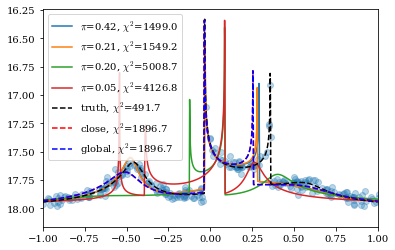

In [68]:
verbose = True

i = 0
best_parameters = []
for index in tqdm(range(4)):
    para_initial = locs_sort[i, index, :-1]
    if verbose:
        print(para_initial)
    para_best, chi2_min, model, warnflag = perform_optimization(lc[i, :, 0], lc[i, :, 2], lc[i, :, 3], para_initial, verbose=verbose)
    best_parameters.append(np.hstack((chi2_min, warnflag, para_best)))
    plt.plot(model[0], model[1], label=r'$\pi$=%.2f, $\chi^2$=%.1f'%(pis_sort[i, index], chi2_min))

def compute_chisq(fitting_parameters, time, flux, ferr, VBBL, return_model=False):
    magnifications = compute_model_lc(time, fitting_parameters, VBBL)
    chi2, fs, fb, fserr, fberr = get_fsfb(magnifications, flux, ferr)
    if return_model:
        return chi2, fs, fb
    return chi2

chi2_min, fs, fb = compute_chisq(Y[i, :-1].numpy(), lc[i, :, 0], lc[i, :, 2], lc[i, :, 3], VBBinaryLensing.VBBinaryLensing(), return_model=True)
time_model = np.arange(-2, 2, 0.001)
magnifications = compute_model_lc(time_model, Y[i, :-1].numpy(), VBBinaryLensing.VBBinaryLensing())
mag_model = 18 - 2.5*np.log10(magnifications*fs + fb)
model = np.vstack((time_model, mag_model))
best_parameters.append(np.hstack((chi2_min, warnflag, para_best)))
plt.plot(model[0], model[1], label=r'truth, $\chi^2$=%.1f' % (chi2_min), color='black', linestyle='--')

chi2_min, fs, fb = compute_chisq(pred_close[i, :-1].numpy(), lc[i, :, 0], lc[i, :, 2], lc[i, :, 3], VBBinaryLensing.VBBinaryLensing(), return_model=True)
time_model = np.arange(-2, 2, 0.001)
magnifications = compute_model_lc(time_model, pred_close[i, :-1].numpy(), VBBinaryLensing.VBBinaryLensing())
mag_model = 18 - 2.5*np.log10(magnifications*fs + fb)
model = np.vstack((time_model, mag_model))
best_parameters.append(np.hstack((chi2_min, warnflag, para_best)))
plt.plot(model[0], model[1], label=r'close, $\chi^2$=%.1f' % (chi2_min), color='red', linestyle='--')

chi2_min, fs, fb = compute_chisq(pred_global[i, :-1].numpy(), lc[i, :, 0], lc[i, :, 2], lc[i, :, 3], VBBinaryLensing.VBBinaryLensing(), return_model=True)
time_model = np.arange(-2, 2, 0.001)
magnifications = compute_model_lc(time_model, pred_global[i, :-1].numpy(), VBBinaryLensing.VBBinaryLensing())
mag_model = 18 - 2.5*np.log10(magnifications*fs + fb)
model = np.vstack((time_model, mag_model))
best_parameters.append(np.hstack((chi2_min, warnflag, para_best)))
plt.plot(model[0], model[1], label=r'global, $\chi^2$=%.1f' % (chi2_min), color='blue', linestyle='--')

best_parameters = np.array(best_parameters)
mdn_add = pandas.DataFrame(best_parameters, columns=('chi2_min', 'fmin_flag', 'u0_best', 'lgq_best', 'lgs_best', 'alpha/180_best'))
mdn = pandas.DataFrame(np.vstack((pis_sort[i], locs_sort[i].T)).T, columns=('weight', 'u0', 'lgq', 'lgs', 'a/180', 'lgfs'))
mdn = mdn.join(mdn_add, how='outer')
if verbose:
    print(mdn[:4])
plt.scatter(lc[i, :, 0], lc[i, :, 1], marker='o', alpha=0.3)
plt.gca().invert_yaxis()
plt.legend(loc=0)
plt.xlim(-1, 1)
plt.show()

In [71]:
print('ground truth: ', Y[i].numpy())
print('global: ', pred_global[i].numpy())
print('close: ', pred_close[i].numpy())
print(mdn.loc[:4, ['weight', 'u0_best', 'lgq_best', 'lgs_best', 'alpha/180_best', 'lgfs']])

ground truth:  [ 0.34033019 -0.35541759  0.01886043  1.18859352 -0.81332128]
global:  [ 0.37037036 -0.3963964   0.02822824  1.1771772  -0.7287287 ]
close:  [ 0.37037036 -0.3963964   0.02822824  1.1771772  -0.7287287 ]
     weight   u0_best  lgq_best  lgs_best  alpha/180_best      lgfs
0  0.423211  0.319682 -0.590147  0.011793        1.179608 -0.758747
1  0.214735  0.317006 -0.617469  0.011599        1.178535 -0.716233
2  0.196685  0.355146 -0.070772  0.088762        0.797525 -0.705945
3  0.051100  0.211450 -0.343122  0.070550        0.806615 -0.800307
4  0.040796  0.211450 -0.343122  0.070550        0.806615 -0.688354


In [61]:
np.savetxt('./lc1.csv', X[i, :, :], delimiter=',')
np.savez('./mdn1.npz', pi=pis[i].numpy(), loc=locs[i].numpy(), scale=scales[i].numpy())

In [75]:
verbose = False

n_gau = 4
best_parameters = np.zeros((100, n_gau, 6))

for i in tqdm(range(100)):
    for index in range(n_gau):
        para_initial = locs_sort[i, index, :-1]
        if verbose:
            print(para_initial)
        para_best, chi2_min, model, warnflag = perform_optimization(lc[i, :, 0], lc[i, :, 2], lc[i, :, 3], para_initial, verbose=verbose)
        best_parameters[i, index] = np.hstack((chi2_min, warnflag, para_best))

  0%|          | 0/100 [00:00<?, ?it/s]

In [90]:
order = np.argsort(best_parameters[:, :, 0], axis=-1)
best_parameters_sort = best_parameters[np.arange(len(order))[:, None], order]

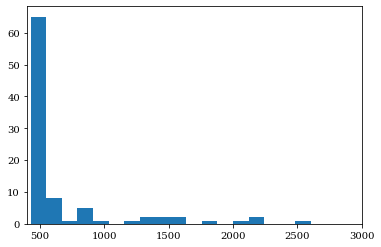

In [102]:
plt.hist(best_parameters_sort[:, 0, 0], bins=100)
plt.xlim(400, 3000)
plt.show()

In [125]:
np.sum(best_parameters_sort[:, 0, 0] < 500)/100

0.41

In [126]:
ind = best_parameters_sort[:, 0, 0] < 500

In [117]:
pred = best_parameters_sort[:, 0, 2:]

In [132]:
def plot_params(num, Y, pred,
                title=None, figsize=(16, 8), labelsize=14, alpha=0.1, save=None,
                ):
    rmse = []

    fig = plt.figure(figsize=figsize)
    axq = plt.subplot2grid(shape=(2, 4), loc=(0, 0), rowspan=1, colspan=1)
    axq.axis('square')
    axq.set_xlim(-3, 0)
    axq.set_ylim(-3, 0)
    axq.set_xlabel(r'true $\lg q$', fontsize=labelsize)
    axq.set_ylabel(r'predicted $\lg q$', fontsize=labelsize)
    axq.scatter(Y[:num, 1], pred[:num, 1], s=3, cmap='Blues', label='global', alpha=alpha, rasterized=True)
    axq.plot(np.linspace(-3, 0), np.linspace(-3, 0), color='b', linestyle='dashed')
    # axq.legend(loc='lower right')
    at = AnchoredText(
        "RMSE=%.4f" % (np.sqrt(torch.mean((Y[:num, 1] -  pred[:num, 1])**2).detach().cpu().item())), prop=dict(size=12), frameon=False, loc='upper left')
    axq.add_artist(at)
    
    axs = plt.subplot2grid(shape=(2, 4), loc=(0, 1), rowspan=1, colspan=1)
    axs.axis('square')
    axs.set_xlim(np.log10(0.3), np.log10(3))
    axs.set_ylim(np.log10(0.3), np.log10(3))
    axs.set_xlabel(r'true $\lg s$', fontsize=labelsize)
    axs.set_ylabel(r'predicted $\lg s$', fontsize=labelsize)
    axs.scatter(Y[:num, 2], pred[:num, 2], s=3, cmap='Blues', label='global', alpha=alpha, rasterized=True)
    axs.plot(np.linspace(-0.6, 0.6), np.linspace(-0.6, 0.6), color='b', linestyle='dashed')
    # axs.legend(loc='lower right')
    at = AnchoredText(
        "RMSE=%.4f" % (np.sqrt(torch.mean((Y[:num, 2] -  pred[:num, 2])**2).detach().cpu().item())), prop=dict(size=12), frameon=False, loc='upper left')
    axs.add_artist(at)

    axu = plt.subplot2grid(shape=(2, 4), loc=(0, 2), rowspan=1, colspan=1)
    axu.axis('square')
    axu.set_xlim(0, 1)
    axu.set_ylim(0, 1)
    axu.set_xlabel(r'true $u_0$', fontsize=labelsize)
    axu.set_ylabel(r'predicted $u_0$', fontsize=labelsize)
    axu.scatter(Y[:num, 0], pred[:num, 0], s=3, cmap='Blues', label='global', alpha=alpha, rasterized=True)
    
    axu.plot(np.linspace(0, 1), np.linspace(0, 1), color='b', linestyle='dashed')
    # axu.legend(loc='lower right')
    at = AnchoredText(
        "RMSE=%.4f" % (np.sqrt(torch.mean((Y[:num, 0] -  pred[:num, 0])**2).detach().cpu().item())), prop=dict(size=12), frameon=False, loc='upper left')
    axu.add_artist(at)

    axa = plt.subplot2grid(shape=(2, 4), loc=(0, 3), rowspan=1, colspan=1)
    axa.axis('square')
    axa.set_xlim(0, 360)
    axa.set_ylim(0, 360)
    axa.set_xlabel(r'true $\alpha$ (deg)', fontsize=labelsize)
    axa.set_ylabel(r'predicted $\alpha$ (deg)', fontsize=labelsize)
    axa.scatter(Y[:num, 3]*180, pred[:num, 3]*180, s=3, cmap='Blues', label='global', alpha=alpha, rasterized=True)
    axa.plot(np.linspace(0, 360), np.linspace(0, 360), color='b', linestyle='dashed')
    # axa.legend(loc='lower right')
    at = AnchoredText(
        "RMSE=%.3f" % np.sqrt((torch.mean((Y[:num, 3] -  pred[:num, 3])**2).detach().cpu().item())*180), prop=dict(size=12), frameon=False, loc='upper left')
    axa.add_artist(at)
    plt.tight_layout()
        
    if title != None:
        fig.suptitle(title)

    if save != None:
        plt.savefig(save)
    
    plt.show()
    return rmse

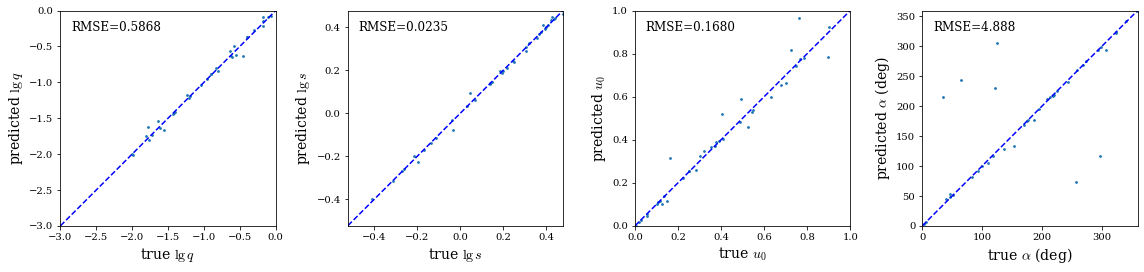

In [133]:
rmse = plot_params(num=41, Y=Y[:100][ind], pred=pred[ind], alpha=1)